In [5]:
# Import necessary libraries
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.applications.efficientnet import preprocess_input
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [6]:
df = pd.read_csv('CBIS-DDSM_combined.csv')
df.head()

,pathology,left or right breast,image view,abnormality type,image_path
0,MALIGNANT,LEFT,CC,mass,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.342386...
1,MALIGNANT,LEFT,MLO,mass,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.359308...
2,BENIGN,LEFT,CC,mass,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.891800...
3,BENIGN,LEFT,MLO,mass,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.295360...
4,BENIGN,RIGHT,MLO,mass,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.410524...


In [7]:
# Label Encoding for the 'pathology' column (MALIGNANT = 1, BENIGN = 0)
label_encoder = LabelEncoder()
df['pathology'] = label_encoder.fit_transform(df['pathology'])
df.head()

,pathology,left or right breast,image view,abnormality type,image_path
0,1,LEFT,CC,mass,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.342386...
1,1,LEFT,MLO,mass,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.359308...
2,0,LEFT,CC,mass,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.891800...
3,0,LEFT,MLO,mass,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.295360...
4,0,RIGHT,MLO,mass,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.410524...


In [8]:
# Prepare the image paths and labels
image_paths = df['image_path'].values
labels = df['pathology'].values

# Train-Test Split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(image_paths, labels, test_size=0.2, random_state=42, stratify=labels)

`preprocess_input` function prepares the image data in a format compatible with the specific pre-trained model EfficientNetB3

Rescale Pixel Values: It scales the pixel values from the range [0, 255] (typical range for RGB images) to a range suitable for the EfficientNet model, typically between [-1, 1]. This step is essential because the EfficientNet model was trained on data where pixel values were normalized in this way.

Normalization Specific to EfficientNet: Every pre-trained model has its own normalization requirements. For EfficientNet models, preprocess_input handles this specific normalization (scaling the pixel values between -1 and 1)

In [9]:
# ImageDataGenerator for rescaling and validation split
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.2)

# Set the seed value for reproducibility in data shuffling
seed_value = 42

# Flowing images from dataframe for training
train_generator = train_datagen.flow_from_dataframe(
    pd.DataFrame({'filename': X_train, 'class': y_train}),
    x_col='filename',
    y_col='class',
    target_size=(300, 300),  # EfficientNetB3 requires 300x300 images
    batch_size=32,
    class_mode='raw',
    shuffle=True,
    subset='training', # this is for training data
    seed=seed_value
)

# Flowing images from dataframe for validation
validation_generator = train_datagen.flow_from_dataframe(
    pd.DataFrame({'filename': X_train, 'class': y_train}),
    x_col='filename',
    y_col='class',
    target_size=(300, 300), 
    batch_size=32,
    class_mode='raw',
    shuffle=False,
    subset='validation', # this is for validation data
    seed=seed_value
)

# Test data generator
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = test_datagen.flow_from_dataframe(
    pd.DataFrame({'filename': X_test, 'class': y_test}),
    x_col='filename',
    y_col='class',
    target_size=(300, 300),  
    batch_size=32,
    class_mode='raw',
    shuffle=False,
    seed=seed_value
)

Found 1833 validated image filenames.
Found 458 validated image filenames.
Found 573 validated image filenames.


In [6]:
# Load the EfficientNetB3 model, with weights pre-trained on ImageNet
efficientnet_base = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(300, 300, 3))  

"""
# Unfreeze the last few layers of the EfficientNetB3 model for fine-tuning
for layer in efficientnet_base.layers[:-20]:  # Keep the first part frozen
    layer.trainable = False
"""

# Freeze the base model layers
efficientnet_base.trainable = False

# Build the model
model = models.Sequential([
    efficientnet_base,  # Pre-trained base EfficientNetB3
    layers.GlobalAveragePooling2D(),  # Global average pooling instead of flattening
    layers.BatchNormalization(),  # Batch normalization
    layers.Dense(256, activation='relu'),  # Larger dense layer
    layers.Dropout(0.5),  # Dropout to prevent overfitting
    layers.Dense(256, activation='relu'),  # Additional dense layer for more complexity
    layers.Dropout(0.3),  # Slightly less dropout on the second layer
    layers.Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Display the model architecture
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb3 (Functional)     │ (None, 10, 10, 1536)   │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1536)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1536)           │         6,144 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       393,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,249,200 (42.91 MB)

 Trainable params: 462,593 (1.76 MB)

 Non-trainable params: 10,786,607 (41.15 MB)

In [7]:
# Callback to save the best model based on validation loss
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    'efficientnetb3_best_model.keras',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

# Train the model with callback
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=50,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=[checkpoint_callback]  # Pass callback
)

c:\Users\abhil.LAPTOP-UDIMD39P\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5506 - loss: 0.8071
Epoch 1: val_loss improved from inf to 0.65516, saving model to efficientnetb3_best_model.keras
58/58 ━━━━━━━━━━━━━━━━━━━━ 222s 4s/step - accuracy: 0.5506 - loss: 0.8070 - val_accuracy: 0.6550 - val_loss: 0.6552
Epoch 2/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5908 - loss: 0.7490
Epoch 2: val_loss improved from 0.65516 to 0.63525, saving model to efficientnetb3_best_model.keras
58/58 ━━━━━━━━━━━━━━━━━━━━ 195s 3s/step - accuracy: 0.5909 - loss: 0.7489 - val_accuracy: 0.6703 - val_loss: 0.6352
Epoch 3/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6207 - loss: 0.6891
Epoch 3: val_loss improved from 0.63525 to 0.62110, saving model to efficientnetb3_best_model.keras
58/58 ━━━━━━━━━━━━━━━━━━━━ 198s 3s/step - accuracy: 0.6206 - loss: 0.6893 - val_accuracy: 0.6790 - val_loss: 0.6211
Epoch 4/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6395 - loss: 0.6674
Epoch 4: val_loss improv

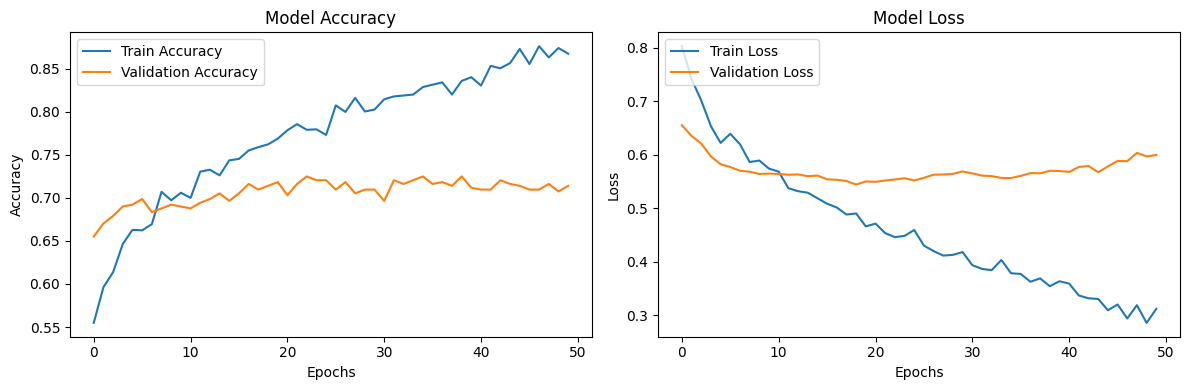

In [11]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
# Load the .keras model
# model = tf.keras.models.load_model('efficientnetb3_best_model.keras')

# Save the model as an .h5 file
model.save('efficientnetb3_best_model.h5')

In [10]:
# Evaluate the model on test data
test_loss, test_acc = model.evaluate(test_generator, steps=len(test_generator))
print(f"Test Accuracy: {test_acc:.4f}")
# model.save('efficientnetb3_model.h5')

c:\Users\abhil.LAPTOP-UDIMD39P\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


18/18 ━━━━━━━━━━━━━━━━━━━━ 54s 3s/step - accuracy: 0.6933 - loss: 0.5861
Test Accuracy: 0.7016


In [3]:
# Load the saved model
from tensorflow.keras.models import load_model
model = load_model('efficientnetb3_best_model.keras')

18/18 ━━━━━━━━━━━━━━━━━━━━ 54s 3s/step


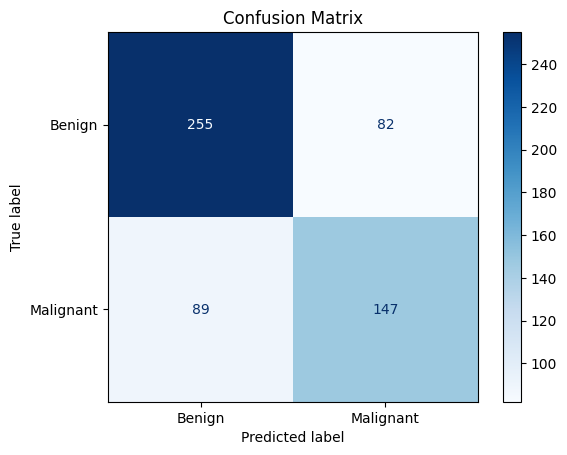

In [14]:
# Import additional necessary libraries
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get the true labels from the test generator
y_true = test_generator.labels
# Predict the labels (these will be probabilities)
y_pred_prob = model.predict(test_generator, steps=len(test_generator))

# Convert predicted probabilities to binary labels (threshold at 0.5)
y_pred = (y_pred_prob > 0.5).astype(int).ravel()

# Step 2: Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Step 3: Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Benign', 'Malignant'])

# Plot the confusion matrix using matplotlib
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np
import tensorflow as tf

# Load the saved model
model = tf.keras.models.load_model('efficientnetb0_model.h5')

# Path to the new image (replace this with your own image path)
img_path = 'CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.342386194811267636608694132590482924515/1-211.jpg' # manlignant

# Load and preprocess the image
img = image.load_img(img_path, target_size=(224, 224))  # Resize to 224x224
img_array = image.img_to_array(img)  # Convert to numpy array
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array = tf.keras.applications.efficientnet.preprocess_input(img_array)  # Preprocess input for EfficientNet

# Predict the class (0 = benign, 1 = malignant)
prediction = model.predict(img_array)
predicted_class = 'Malignant' if prediction[0][0] >= 0.5 else 'Benign'

# Output the result
print(f"The model predicts this image is: {predicted_class}")
